# Converting File to CSV because of Excel Loading issues

In [1]:
import pandas as pd


df = pd.read_excel(
    '/Users/hatim/Desktop/OCTAVE/spark exercise/Data/Colombo-Cab-data-2.xlsx',
    sheet_name='Sheet 1 - Colombo-Cab-data',
    header=1  # second row is the header
)

df['DropOff_Colombo_ID'] = df['DropOff_Colombo_ID'].round(0).astype(int)
df.to_csv('/Users/hatim/Desktop/OCTAVE/spark exercise/Data/Colombo-Cab-data.csv', index=False)

# Create Spark Session and load in data

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .appName("cabs") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/05/23 14:11:12 WARN Utils: Your hostname, Macmanjee-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.30 instead (on interface en0)
25/05/23 14:11:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/23 14:11:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
path = '/Users/hatim/Desktop/OCTAVE/spark exercise/Data/Colombo-Cab-data.csv'

df = spark.read \
            .format("csv") \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .load(path)

df

Cab_Driver_ID,Gender,PickUp_Colombo_ID,DropOff_Colombo_ID,N_Passengers,Date,PickUp_Time,Duration_Min,Tip,Total_Amount
5,M,2,7,1,2021-10-20,Day,25,4.56,26.31
20,F,11,11,4,2021-09-03,Night,25,0.57,22.32
16,F,11,12,1,2021-09-22,Day,48,3.89,45.65
7,M,15,13,3,2021-07-19,Day,30,9.64,35.74
15,F,5,13,1,2021-11-20,Day,37,5.12,37.31
9,M,7,3,4,2021-12-07,Night,33,2.83,31.54
3,M,14,3,3,2021-11-21,Day,34,1.03,30.61
11,M,7,2,3,2021-10-01,Night,38,2.97,36.03
4,M,11,6,4,2021-10-14,Night,38,2.34,35.4
5,M,8,9,2,2021-09-27,Day,51,2.75,47.12


# Part 1


Descriptions
- cab driver ID is a unique identifier for each cab driver (int). This is categorical in nature
- gender is a binary variable (converting to 1 and 0 and labelling is_Male)
- pickup and dropoff locations are categorical variables (converting to string)
- N_passengers is an integer variable (its ordinal so we can leave it as it is)
- Date is a data object
- pickup time is a categorical variable (keep as string)
- duration is an integer variable (keep as it is)
- tip is a float and continuous variable
- total amount is a float and continuous variable

Note:
- used the datawrangler extension to get a snapshot of the data. No missing values, Checked distributions, etc.

In [4]:
df.printSchema()

root
 |-- Cab_Driver_ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- PickUp_Colombo_ID: integer (nullable = true)
 |-- DropOff_Colombo_ID: integer (nullable = true)
 |-- N_Passengers: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- PickUp_Time: string (nullable = true)
 |-- Duration_Min: integer (nullable = true)
 |-- Tip: double (nullable = true)
 |-- Total_Amount: double (nullable = true)



## Do Some Preprocessing

In [5]:
from pyspark.sql.functions import when

# convert gender to a binary variable
df = df.withColumn("Gender", when(df["Gender"] == "M", 1).otherwise(0))
df = df.withColumnRenamed("Gender", "IsMale") # rename the column to IsMale


In [6]:
# convert drop off and pickup to string
df = df.withColumn("PickUp_Colombo_ID", df["PickUp_Colombo_ID"].cast("string"))
df = df.withColumn("DropOff_Colombo_ID", df["DropOff_Colombo_ID"].cast("string"))

Notes for regression
- one hot encode pickup and dropoff locations - they're categorical variables. same for pickup time
- For Date, maybe create some fourier terms (but interpretability might be problematic) or extract the day, day of week, and month as categorical variables
- There will most likely be a close interaction between tip and total amount so need to do something about that when predicting (lookahead bias)

In [7]:
df

Cab_Driver_ID,IsMale,PickUp_Colombo_ID,DropOff_Colombo_ID,N_Passengers,Date,PickUp_Time,Duration_Min,Tip,Total_Amount
5,1,2,7,1,2021-10-20,Day,25,4.56,26.31
20,0,11,11,4,2021-09-03,Night,25,0.57,22.32
16,0,11,12,1,2021-09-22,Day,48,3.89,45.65
7,1,15,13,3,2021-07-19,Day,30,9.64,35.74
15,0,5,13,1,2021-11-20,Day,37,5.12,37.31
9,1,7,3,4,2021-12-07,Night,33,2.83,31.54
3,1,14,3,3,2021-11-21,Day,34,1.03,30.61
11,1,7,2,3,2021-10-01,Night,38,2.97,36.03
4,1,11,6,4,2021-10-14,Night,38,2.34,35.4
5,1,8,9,2,2021-09-27,Day,51,2.75,47.12


# Part 2

In [8]:
cats = ['Cab_Driver_ID', 'PickUp_Colombo_ID', 'DropOff_Colombo_ID', 'PickUp_Time']
nums = ['IsMale', 'N_Passengers', 'Duration_Min', 'Tip', 'Total_Amount']
date = ['Date']
    

## Numerical Features

In [9]:
numerical_df = df.select(nums+['PickUp_Colombo_ID', 'DropOff_Colombo_ID'])

numerical_df = numerical_df.withColumn("PickUp_Colombo_ID", numerical_df["PickUp_Colombo_ID"].cast("Int"))
numerical_df = numerical_df.withColumn("DropOff_Colombo_ID", numerical_df["DropOff_Colombo_ID"].cast("Int"))

num_summary = numerical_df.summary()

num_summary

summary,IsMale,N_Passengers,Duration_Min,Tip,Total_Amount,PickUp_Colombo_ID,DropOff_Colombo_ID
count,999,999,999,999,999,999,999
mean,0.6316316316316316,2.4824824824824825,30.47747747747748,4.985955955955961,31.50136136136136,7.914914914914915,7.85985985985986
stddev,0.4826036188699095,1.129599678785395,14.594768163926451,2.9691041782505154,12.96989724777279,4.3316618469682915,4.388496117889801
min,0,1,7,0.0,6.39,1,0
25%,0,1,17,2.37,20.28,4,4
50%,1,2,30,5.04,31.56,8,8
75%,1,3,43,7.51,42.19,12,12
max,1,4,55,9.99,57.35,15,15


## Categorical Features


In [10]:
def get_counts(df):
    for cat in df.columns:
        counts =  df.groupBy(cat).count().orderBy("count", ascending=False)
        counts = counts.toPandas().set_index(cat)
        yield counts.T



generator = get_counts(df.select(cats+['Date']))

In [11]:
next(generator)

Cab_Driver_ID,18,11,14,5,12,13,20,17,8,3,15,4,1,16,6,19,9,10,7,2
count,63,62,58,56,54,53,53,52,52,48,48,48,47,47,47,47,47,44,37,36


In [12]:
next(generator)

PickUp_Colombo_ID,14,10,4,1,7,3,5,2,8,9,11,13,15,6,12
count,80,79,71,70,69,69,68,67,65,65,61,60,59,59,57


In [13]:
next(generator)

DropOff_Colombo_ID,14,10,12,13,8,5,9,6,7,3,11,2,1,4,15,0
count,80,78,70,69,68,67,67,66,64,63,61,59,58,52,43,34


In [14]:
# explore colombo 0 dropoff - these look like valid routes - they are most likely when dropoff is in the suburbs and pickup is in the city so we leave them as is
df.filter(df["DropOff_Colombo_ID"] == 0).show()

+-------------+------+-----------------+------------------+------------+----------+-----------+------------+----+------------+
|Cab_Driver_ID|IsMale|PickUp_Colombo_ID|DropOff_Colombo_ID|N_Passengers|      Date|PickUp_Time|Duration_Min| Tip|Total_Amount|
+-------------+------+-----------------+------------------+------------+----------+-----------+------------+----+------------+
|           14|     0|                1|                 0|           2|2021-08-01|      Night|          32|4.27|       32.11|
|            2|     1|               13|                 0|           3|2021-11-07|        Day|          36|7.07|       38.39|
|            5|     1|                7|                 0|           2|2021-11-01|        Day|          26|1.38|        24.0|
|           15|     0|               12|                 0|           4|2021-12-17|        Day|           7|0.81|         6.9|
|            6|     1|                9|                 0|           2|2021-10-12|        Day|          39|2.3

In [15]:
next(generator)

PickUp_Time,Day,Night
count,686,313


## Dates

In [16]:
from pyspark.sql.functions import col, min, max, countDistinct, count

date_summary = df.select(
    min(col("Date")).alias("earliest_date"),
    max(col("Date")).alias("latest_date"),
    countDistinct(col("Date")).alias("distinct_dates_count"),
    count(col("Date")).alias("total_dates_count")
).first()


print(f"Earliest Date: {date_summary['earliest_date']}")
print(f"Latest Date: {date_summary['latest_date']}")
print(f"Number of Distinct Dates: {date_summary['distinct_dates_count']}")
print(f"Total Number of Dates: {date_summary['total_dates_count']}")

Earliest Date: 2021-07-01
Latest Date: 2021-12-31
Number of Distinct Dates: 183
Total Number of Dates: 999


# Part 3

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

## Part A

We can do this in 2 different ways:
1. Average the entire nightly series - this is the average trip amount nightly
2. Get how much each driver makes on average per night and get the average of that - this is the average trip amount per driver nightly

Results:
- Average trip amount per driver per night: 31.42
- From the first plot it seems like male and femaile drivers make similar amounts per night on average and the histogram also seems to support this. t-test confirms that there is no statistically significant difference




Average trip amount per night: 31.65
CodeCache: size=131072Kb used=38534Kb max_used=38546Kb free=92537Kb
 bounds [0x00000001099f8000, 0x000000010bfd8000, 0x00000001119f8000]
 total_blobs=13521 nmethods=12536 adapters=892
 compilation: disabled (not enough contiguous free space left)
Average trip amount per driver per night: 31.42


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


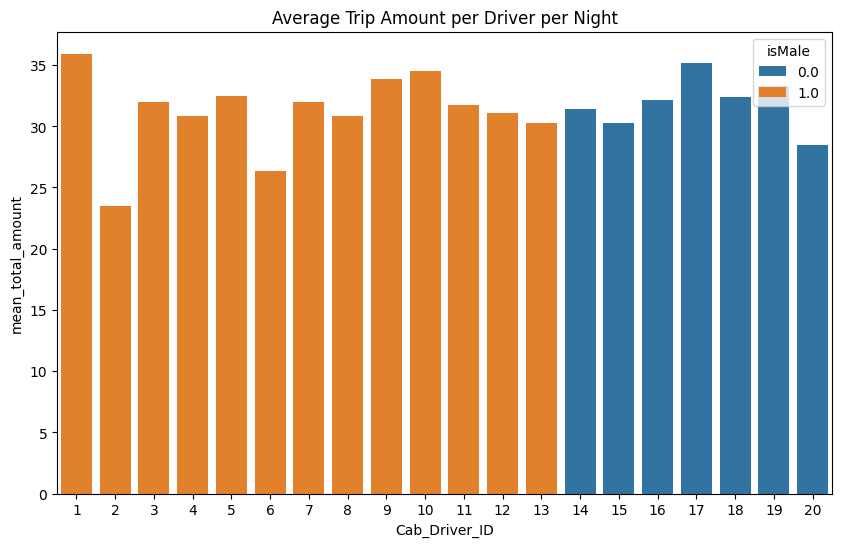

In [18]:
from pyspark.sql.functions import mean

# filter for night time
driver_night = df.filter(df["PickUp_Time"] == "Night").select("Cab_Driver_ID", 'Total_Amount', 'IsMale')


# aproach 1 - average trip amount nightly
total_mean = driver_night.agg(mean("Total_Amount")).first()[0]
print(f"Average trip amount per night: {round(total_mean, 2)}")


# aproach 2 - average trip amount per driver nightly
# get how much each driver makes nightly on average
per_driver = driver_night.groupBy("Cab_Driver_ID").agg(mean("Total_Amount").alias("mean_total_amount"), mean("IsMale").alias("isMale"))

# get the average of series
per_driver_mean = per_driver.agg(mean("mean_total_amount")).first()[0]
print(f"Average trip amount per driver per night: {round(per_driver_mean, 2)}")



# plot per_driver earnings as a bar chart
fig = plt.figure(figsize=(10, 6))
sns.barplot(y="mean_total_amount", x="Cab_Driver_ID", hue='isMale',data=per_driver.toPandas())
plt.title("Average Trip Amount per Driver per Night")
plt.show()


Male Mean Fare: 31.5066561014263 (N = 631)
Female Mean Fare: 31.492282608695653 (N = 368)


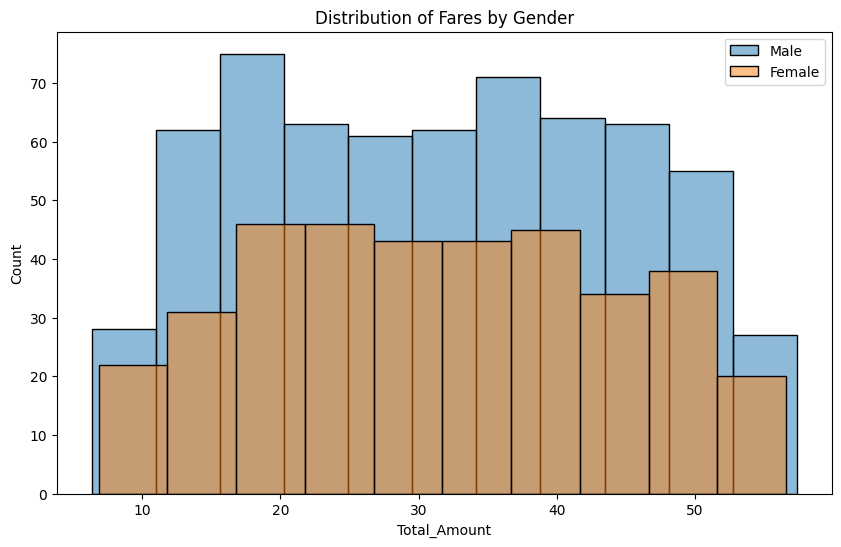

In [19]:
# count number of males and females
male_fares = df.filter(df["IsMale"] == 1).toPandas()['Total_Amount']
female_fares = df.filter(df["IsMale"] == 0).toPandas()['Total_Amount']
print(f"Male Mean Fare: {male_fares.mean()} (N = {male_fares.count()})")
print(f"Female Mean Fare: {female_fares.mean()} (N = {female_fares.count()})")

# plot an overlayed histogram of the fares by gender. count should be on the axis axis
fig = plt.figure(figsize=(10, 6))
sns.histplot(male_fares, label="Male", alpha=0.5)
sns.histplot(female_fares, label="Female", alpha=0.5)
plt.title("Distribution of Fares by Gender")
plt.legend()
plt.show()

In [20]:
from scipy.stats import ttest_ind

t_statistic, p_value_ttest = ttest_ind(male_fares, female_fares, equal_var=True, alternative='two-sided')
print(f"T-test p-value: {p_value_ttest}")
if p_value_ttest < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

T-test p-value: 0.9865297861011163
Fail to reject the null hypothesis


## Part B



$H_0$: There is no difference in the average money made on weekends

$H_1$: Cab drivers make more money on weekends compared to weekdays.

Assumptions of 2 sample t-test:
- Independence of observations: This we can assume to be true as the data is collected from different days and different drivers.
- Normality: Our samples are fairly large so the t-test should be robust to violations of normality.
- Equal variances : This we need to check using a F-test for equal variances.

Result:
- We fail to reject the null hypothesis. There is not enough evidence to say that cab drivers make more money on weekends compared to weekdays.

In [21]:
from pyspark.sql.functions import date_format
import numpy as np

# add a column for the day of the week
df = df.withColumn("DayOfWeek", date_format(col("Date"), "EEEE"))

# get 2 lists of the total amount for weekends and weekdays
weekend = df.filter(df["DayOfWeek"].isin("Saturday", "Sunday")).select("Total_Amount")
weekend_list = np.array([row["Total_Amount"] for row in weekend.collect()])

weekday = df.filter(~df["DayOfWeek"].isin("Saturday", "Sunday")).select("Total_Amount")
weekday_list = np.array([row["Total_Amount"] for row in weekday.collect()])



print(f"Average trip amount on weekends: {round(np.mean(weekend_list), 2)} (N = {len(weekend_list)})")
print(f"Average trip amount on weekdays: {round(np.mean(weekday_list), 2)} (N = {len(weekday_list)})")

Average trip amount on weekends: 32.37 (N = 305)
Average trip amount on weekdays: 31.12 (N = 694)


In [22]:
# Check for equal variance
from scipy.stats import f_oneway

f_test = f_oneway(weekend_list, weekday_list)
print(f"F-test for equal variances: {'pass' if f_test.pvalue > 0.05 else 'fail'}")

F-test for equal variances: pass


In [23]:
# f-test passed so can do a t-test


# 'greater' says the first sample (weekend) is greater than the second sample (weekday)
t_statistic, p_value_ttest = ttest_ind(weekend_list, weekday_list, equal_var=True, alternative='greater')
print(f"T-test p-value: {p_value_ttest}")
if p_value_ttest < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

T-test p-value: 0.07997598051762189
Fail to reject the null hypothesis


## Part C

Define groups:
- overall
- men/day
- men/night
- women/day
- women/night

Step 1: Visualize the means for all categories
- get means by area for each group.
- Then plot in a bar graph

Then for each group do:

Step 2: Statistical tests
- Check for normality (Shapiro-wilk) of each state and then for equal variances (Levene's test)
- Do ANOVA to understand if there is a statistically significant difference between the groups
- for all pairs, do mannwhitney u test to check for differences between each pair. (robust to non-normality and unqual variances). Apply a bonferroni correction to the p-values.
- for the statistically significant pairs, rank the states by median earnings.




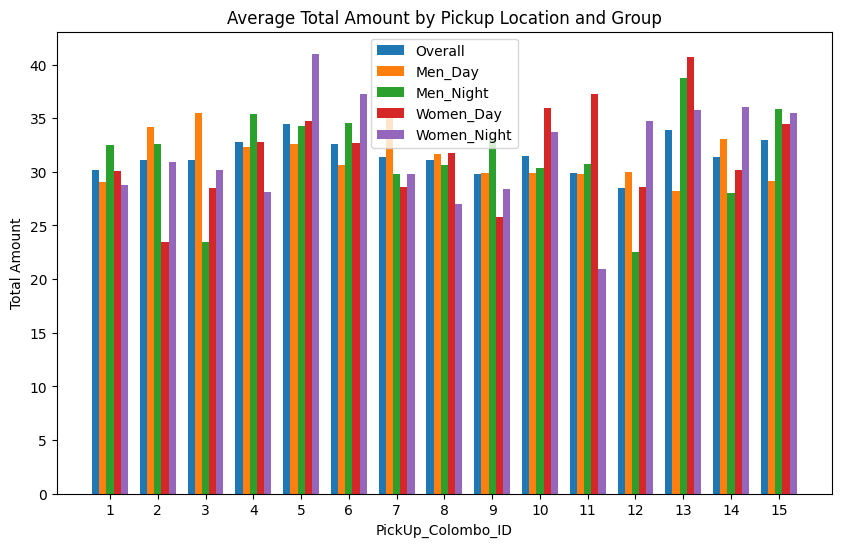

In [24]:
# prepare the data
def get_state_average(df, name = "Overall"):
    grouping = df.groupBy("PickUp_Colombo_ID").agg(mean("Total_Amount").alias(name)).toPandas()
    grouping["PickUp_Colombo_ID"] = grouping["PickUp_Colombo_ID"].astype(int)
    grouping.sort_values(by="PickUp_Colombo_ID", inplace=True)
    return grouping.set_index("PickUp_Colombo_ID")

# overall
grouped = get_state_average(df)

# men/day
grouped['Men_Day'] = get_state_average(df.filter(df["IsMale"] == 1).filter( df["PickUp_Time"] == "Day"), "Men_Day")

# men/night
grouped['Men_Night'] = get_state_average(df.filter(df["IsMale"] == 1).filter( df["PickUp_Time"] == "Night"), "Men_Night")

# women/day
grouped['Women_Day'] = get_state_average(df.filter(df["IsMale"] == 0).filter( df["PickUp_Time"] == "Day"), "Women_Day")

# women/night
grouped['Women_Night'] = get_state_average(df.filter(df["IsMale"] == 0).filter( df["PickUp_Time"] == "Night"), "Women_Night")


# plot a bar graph with multiple bars for each group next to each other
fig = plt.figure(figsize=(10, 6))

# Create a grouped bar plot
x = np.arange(len(grouped.index))
width = 0.15  # Width of each bar

for i, group in enumerate(grouped.columns):
    plt.bar(x + (i * width), grouped[group], width, label=group)

plt.xlabel('PickUp_Colombo_ID')
plt.ylabel('Total Amount')
plt.title('Average Total Amount by Pickup Location and Group')
plt.xticks(x + width * 2, grouped.index)
plt.legend()

plt.show()


### Statistical Tests
- The series are mostly not normally distributed so the following should be taken with a grain of salt.
- ANOVA passed only in 1 group (women/day). Here normality held (except only 1 case) and equal variances held to there is something to look into.
- For the pairwise tests, there is a statistically significant difference between many pairs but after applying bonferroni correction, no pairs seem to be significant. Bonferroni is very strict so it is possible that a difference exists so we look at the median earnings for the pairs that were significant without the correction.
- Note that because of the above two, the rankings may not be entirely accurate.

In [25]:
import itertools
from scipy.stats import mannwhitneyu, shapiro, levene
from statsmodels.sandbox.stats.multicomp import multipletests
from pyspark.sql.functions import collect_list


def get_lists(df, group='PickUp_Colombo_ID'):
    # condense the data by pickup location
    condensed = df.groupBy(group).agg(collect_list("Total_Amount").alias("earnings"))
    # collect the data into a list of rows
    data_for_tests = condensed.collect()
    # create a dictionary of pickup location and earnings
    data_dict = {row[group]: row['earnings'] for row in data_for_tests}
    return data_dict


    for state_id, earnings in testing_data.items():
        if any(earning <= 0 for earning in earnings):
            print(f"State {state_id}: Contains non-positive values. Cannot log transform.")
            continue
        testing_data[state_id] = np.log(earnings)
    return testing_data


def check_normality(testing_data):
    print("\n--- Normality Check (Shapiro-Wilk Test) ---")
    for state_id, earnings in testing_data.items():
        if len(earnings) < 3: # Shapiro-Wilk needs at least 3 samples
            print(f"State {state_id}: Not enough data to test normality ( N < 3 ).")
            continue
        stat, p = shapiro(earnings)
        is_normal = p > 0.05
        print(f"State {state_id}: P-value={p:.3f}\t -> {'Normal' if is_normal else 'Not Normal'}")


def check_homogeneity_of_variances(testing_data):
    print("\n--- Homogeneity of Variances Check (Levene's Test) ---")
    # Filter out states with less than 2 samples for Levene's test
    samples_for_levene = [np.array(earnings) for earnings in testing_data.values() if len(earnings) >= 2]

    if len(samples_for_levene) < 2:
        print("Not enough groups with sufficient data to perform Levene's test (need at least 2 groups with N >= 2).")
        return
    stat, p = levene(*samples_for_levene)
    are_variances_equal = p > 0.05
    print(f"Levene's Test: P-value={p:.3f}\t -> {'Variances Equal' if are_variances_equal else 'Variances Not Equal'}")
    print()


def run_anova(testing_data):
    # get the data into a list
    data_list = list(testing_data.values())
    # run the ANOVA
    f_statistic, p_value = f_oneway(*data_list)
    print(f"ANOVA: P-value={p_value:.3f}")
    if p_value < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There is no statistically significant difference between the groups")

    print()



def pairwise_mannwhitneyu(testing_data):
    # get combinations
    state_ids = list(testing_data.keys())
    pairs = list(itertools.combinations(state_ids, 2))

    # initialise results list
    results = []
    raw_p_values = []

    # main loop
    for state1_id, state2_id in pairs:
        earnings1 = testing_data[state1_id]
        earnings2 = testing_data[state2_id]
        stat, p_value = mannwhitneyu(earnings1, earnings2)

        # append results
        results.append({
            'state1': state1_id,
            'state2': state2_id,
            'median1': np.median(earnings1) if earnings1 else np.nan,
            'median2': np.median(earnings2) if earnings2 else np.nan,
            'p_value_raw': p_value
        })

        raw_p_values.append(p_value)
    

    # adjust p-values (bonferroni correction)
    reject, corrected_p_values, _, _ = multipletests(raw_p_values, method='bonferroni')

    adj_p_idx = 0
    for res_dict in results:
        if not np.isnan(res_dict['p_value_raw']):
                res_dict['p_value_adjusted'] = corrected_p_values[adj_p_idx]
                res_dict['significant_after_adj'] = reject[adj_p_idx]
                adj_p_idx += 1
        else:
            res_dict['p_value_adjusted'] = np.nan
            res_dict['significant_after_adj'] = 'N/A'

    return pd.DataFrame(results)



def order_by_median(results_df, col='Overall'):
    orderings = results_df[results_df['p_value_raw']< 0.05]

    # stack the 2 states and their medians
    o1 = orderings[['state1', 'median1']]
    o2 = orderings[['state2', 'median2']]
    o1.columns = ['state', col]
    o2.columns = ['state', col]
    o = pd.concat([o1, o2])
    # drop duplicates
    o = o.drop_duplicates(subset='state')
    o.sort_values(by=col, ascending=False, inplace=True)
    o.set_index('state', inplace=True)
    return o

#### Overall

In [26]:
testing_data = get_lists(df)

# check assumptions
check_normality(testing_data)
check_homogeneity_of_variances(testing_data)

# run tests
run_anova(testing_data)
results_df = pairwise_mannwhitneyu(testing_data)

# save ranking and show significant results
res = order_by_median(results_df)
results_df[results_df['p_value_raw']< 0.05]


--- Normality Check (Shapiro-Wilk Test) ---
State 7: P-value=0.023	 -> Not Normal
State 15: P-value=0.128	 -> Normal
State 11: P-value=0.012	 -> Not Normal
State 3: P-value=0.071	 -> Normal
State 8: P-value=0.062	 -> Normal
State 5: P-value=0.008	 -> Not Normal
State 6: P-value=0.035	 -> Not Normal
State 9: P-value=0.012	 -> Not Normal
State 1: P-value=0.086	 -> Normal
State 10: P-value=0.005	 -> Not Normal
State 4: P-value=0.050	 -> Normal
State 12: P-value=0.033	 -> Not Normal
State 13: P-value=0.005	 -> Not Normal
State 14: P-value=0.067	 -> Normal
State 2: P-value=0.002	 -> Not Normal

--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: P-value=0.935	 -> Variances Equal

ANOVA: P-value=0.484
There is no statistically significant difference between the groups



,state1,state2,median1,median2,p_value_raw,p_value_adjusted,significant_after_adj
29,11,5,27.430,34.815,0.041324,1.0,False
61,5,9,34.815,28.740,0.043276,1.0,False
62,5,1,34.815,29.085,0.040101,1.0,False
65,5,12,34.815,27.480,0.015145,1.0,False
99,12,13,27.480,36.455,0.026647,1.0,False


#### Men/Day

In [27]:
testing_data = get_lists(df.filter(df['IsMale'] == 1).filter(df['PickUp_Time'] == 'Day'))

# check assumptions
check_normality(testing_data)
check_homogeneity_of_variances(testing_data)

# run tests
run_anova(testing_data)
results_df = pairwise_mannwhitneyu(testing_data)

# save ranking and show significant results
res['Men_Day'] = order_by_median(results_df, 'Men_Day')
results_df[results_df['p_value_raw']< 0.05]


--- Normality Check (Shapiro-Wilk Test) ---
State 7: P-value=0.022	 -> Not Normal
State 15: P-value=0.448	 -> Normal
State 11: P-value=0.014	 -> Not Normal
State 3: P-value=0.668	 -> Normal
State 8: P-value=0.342	 -> Normal
State 5: P-value=0.013	 -> Not Normal
State 6: P-value=0.237	 -> Normal
State 9: P-value=0.036	 -> Not Normal
State 1: P-value=0.679	 -> Normal
State 10: P-value=0.029	 -> Not Normal
State 4: P-value=0.252	 -> Normal
State 12: P-value=0.153	 -> Normal
State 13: P-value=0.147	 -> Normal
State 14: P-value=0.654	 -> Normal
State 2: P-value=0.039	 -> Not Normal

--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: P-value=0.717	 -> Variances Equal

ANOVA: P-value=0.596
There is no statistically significant difference between the groups



,state1,state2,median1,median2,p_value_raw,p_value_adjusted,significant_after_adj
47,3,13,35.07,24.31,0.04037,1.0,False


#### Men Night

In [28]:
testing_data = get_lists(df.filter(df['IsMale'] == 1).filter(df['PickUp_Time'] == 'Night'))

# check assumptions
check_normality(testing_data)
check_homogeneity_of_variances(testing_data)

# run tests
run_anova(testing_data)
results_df = pairwise_mannwhitneyu(testing_data)

# save ranking and show significant results
res['Men_Night'] = order_by_median(results_df, 'Men_Night')
results_df[results_df['p_value_raw']< 0.05]



--- Normality Check (Shapiro-Wilk Test) ---
State 7: P-value=0.351	 -> Normal
State 15: P-value=0.046	 -> Not Normal
State 11: P-value=0.627	 -> Normal
State 3: P-value=0.244	 -> Normal
State 8: P-value=0.816	 -> Normal
State 5: P-value=0.150	 -> Normal
State 6: P-value=0.560	 -> Normal
State 9: P-value=0.193	 -> Normal
State 1: P-value=0.894	 -> Normal
State 10: P-value=0.306	 -> Normal
State 4: P-value=0.218	 -> Normal
State 12: P-value=0.010	 -> Not Normal
State 13: P-value=0.077	 -> Normal
State 14: P-value=0.456	 -> Normal
State 2: P-value=0.646	 -> Normal

--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: P-value=0.956	 -> Variances Equal

ANOVA: P-value=0.193
There is no statistically significant difference between the groups



,state1,state2,median1,median2,p_value_raw,p_value_adjusted,significant_after_adj
15,15,3,38.20,23.18,0.014960,1.000000,False
23,15,12,38.20,20.08,0.048856,1.000000,False
43,3,1,23.18,34.21,0.048587,1.000000,False
47,3,13,23.18,42.61,0.007697,0.808182,False
65,5,12,29.69,20.08,0.015115,1.000000,False
86,1,12,34.21,20.08,0.029273,1.000000,False
95,4,12,40.30,20.08,0.045487,1.000000,False
99,12,13,20.08,42.61,0.023851,1.000000,False
102,13,14,42.61,27.93,0.023587,1.000000,False


#### Women Day

In [29]:
testing_data = get_lists(df.filter(df['IsMale'] == 0).filter(df['PickUp_Time'] == 'Day'))

# check assumptions
check_normality(testing_data)
check_homogeneity_of_variances(testing_data)

# run tests
run_anova(testing_data)
results_df = pairwise_mannwhitneyu(testing_data)

# save ranking and show significant results
res['Women_Day'] = order_by_median(results_df, 'Women_Day')
results_df[results_df['p_value_raw']< 0.05]



--- Normality Check (Shapiro-Wilk Test) ---
State 7: P-value=0.165	 -> Normal
State 15: P-value=0.110	 -> Normal
State 11: P-value=0.435	 -> Normal
State 3: P-value=0.122	 -> Normal
State 8: P-value=0.629	 -> Normal
State 5: P-value=0.621	 -> Normal
State 6: P-value=0.381	 -> Normal
State 9: P-value=0.625	 -> Normal
State 1: P-value=0.260	 -> Normal
State 10: P-value=0.721	 -> Normal
State 4: P-value=0.704	 -> Normal
State 12: P-value=0.605	 -> Normal
State 13: P-value=0.408	 -> Normal
State 14: P-value=0.169	 -> Normal
State 2: P-value=0.043	 -> Not Normal

--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: P-value=0.144	 -> Variances Equal

ANOVA: P-value=0.042
There is a statistically significant difference between the groups



,state1,state2,median1,median2,p_value_raw,p_value_adjusted,significant_after_adj
11,7,13,25.235,40.06,0.024047,1.000000,False
26,15,2,29.700,19.29,0.007569,0.794782,False
47,3,13,24.000,40.06,0.011043,1.000000,False
57,8,13,32.275,40.06,0.040987,1.000000,False
59,8,2,32.275,19.29,0.040364,1.000000,False
61,5,9,34.350,22.90,0.029273,1.000000,False
68,5,2,34.350,19.29,0.006190,0.649932,False
76,6,2,30.475,19.29,0.034449,1.000000,False
78,9,10,22.900,36.78,0.025635,1.000000,False
81,9,13,22.900,40.06,0.002523,0.264896,False


#### Women Night

In [30]:

testing_data = get_lists(df.filter(df['IsMale'] == 0).filter(df['PickUp_Time'] == 'Night'))

# check assumptions
check_normality(testing_data)
check_homogeneity_of_variances(testing_data)

# run tests
run_anova(testing_data)
results_df = pairwise_mannwhitneyu(testing_data)

# save ranking and show significant results
res['Women_Night'] = order_by_median(results_df, 'Women_Night')
results_df[results_df['p_value_raw']< 0.05]



--- Normality Check (Shapiro-Wilk Test) ---
State 7: P-value=0.554	 -> Normal
State 15: P-value=0.948	 -> Normal
State 11: P-value=0.500	 -> Normal
State 3: P-value=0.366	 -> Normal
State 8: P-value=0.324	 -> Normal
State 5: P-value=0.114	 -> Normal
State 6: P-value=0.221	 -> Normal
State 9: P-value=0.161	 -> Normal
State 1: P-value=0.955	 -> Normal
State 10: P-value=0.072	 -> Normal
State 4: P-value=0.324	 -> Normal
State 12: P-value=0.887	 -> Normal
State 13: P-value=0.444	 -> Normal
State 14: P-value=0.400	 -> Normal
State 2: P-value=0.516	 -> Normal

--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: P-value=0.844	 -> Variances Equal

ANOVA: P-value=0.175
There is no statistically significant difference between the groups



,state1,state2,median1,median2,p_value_raw,p_value_adjusted,significant_after_adj
1,7,11,29.77,21.68,0.022902,1.000000,False
4,7,5,29.77,42.20,0.022902,1.000000,False
14,15,11,33.70,21.68,0.025574,1.000000,False
29,11,5,21.68,42.20,0.003569,0.374706,False
30,11,6,21.68,43.78,0.017118,1.000000,False
35,11,12,21.68,34.52,0.006993,0.734266,False
36,11,13,21.68,39.74,0.042260,1.000000,False
37,11,14,21.68,37.84,0.016434,1.000000,False
62,5,1,42.20,28.07,0.049550,1.000000,False
64,5,4,42.20,26.26,0.046401,1.000000,False


### Results
- The results between the statistical tests and the mean earnings are somehwat inconsistent. The statistical tests show only signficant differences, but there is higher chance of type 1 error because of the multiple comparisons that we dont apply bonferroni correction to.

However, the following can be deduced:
- overall staying in colombo 5 or 13 seems to be the best option.
- For men during the day, the tests do not agree and nor does ANOVA find differences so we can say that there is no statistically significant difference.
- For men in the night, 13 is agreed by both methods to be the best option. 15 did not have any signifiant comparison so it may be very similar to 13 but also similar to lower order locations.
- For women during the day, 13 is the best option. Apart from that there is nothing consistent
- For women in the night, 5 seems to be the best option.





In [31]:
# display sorted idx for each group
for group in grouped.columns:
    print(group)
    print(f'Order by Mean: \t\t\t{grouped[group].sort_values(ascending=False).index.tolist()}')
    print(f'Order by statistical test: \t{res[group].sort_values(ascending=False).index.tolist()}')
    print("\n")

Overall
Order by Mean: 			[5, 13, 15, 4, 6, 10, 7, 14, 8, 3, 2, 1, 11, 9, 12]
Order by statistical test: 	['13', '5', '1', '9', '12', '11']


Men_Day
Order by Mean: 			[3, 7, 2, 14, 5, 4, 8, 6, 12, 10, 9, 11, 15, 1, 13]
Order by statistical test: 	['13', '5', '1', '9', '12', '11']


Men_Night
Order by Mean: 			[13, 15, 4, 6, 5, 9, 2, 1, 11, 8, 10, 7, 14, 3, 12]
Order by statistical test: 	['13', '1', '5', '12', '9', '11']


Women_Day
Order by Mean: 			[13, 11, 10, 5, 15, 4, 6, 8, 14, 1, 7, 12, 3, 9, 2]
Order by statistical test: 	['13', '5', '12', '1', '9', '11']


Women_Night
Order by Mean: 			[5, 6, 14, 13, 15, 12, 10, 2, 3, 7, 1, 9, 4, 8, 11]
Order by statistical test: 	['5', '13', '12', '1', '11', '9']




## Part D

In [32]:
tips = df.select('PickUp_Colombo_ID','Tip','Total_Amount')
tips = tips.withColumn('Tip_Percentage', tips['Tip']/tips['Total_Amount'])
tips.show(5)

+-----------------+----+------------+-------------------+
|PickUp_Colombo_ID| Tip|Total_Amount|     Tip_Percentage|
+-----------------+----+------------+-------------------+
|                2|4.56|       26.31| 0.1733181299885975|
|               11|0.57|       22.32|0.02553763440860215|
|               11|3.89|       45.65|0.08521358159912377|
|               15|9.64|       35.74| 0.2697257974258534|
|                5|5.12|       37.31|0.13722862503350308|
+-----------------+----+------------+-------------------+
only showing top 5 rows



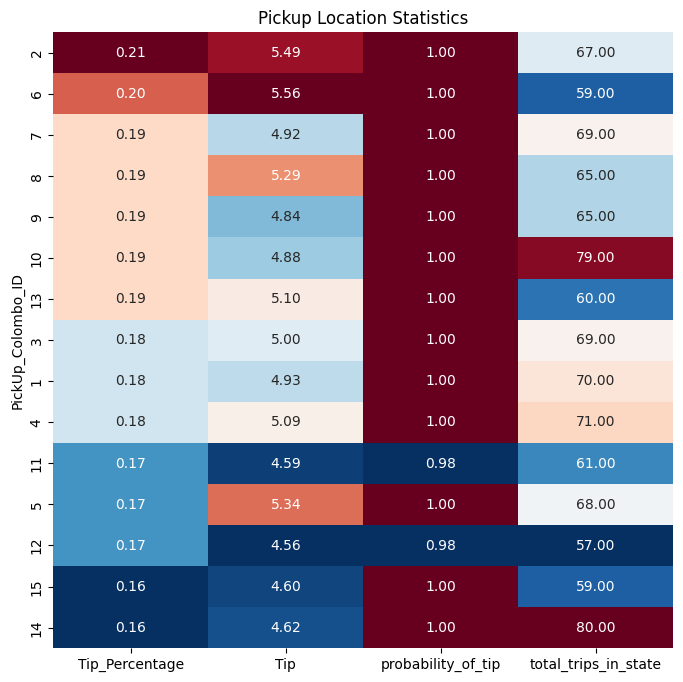

In [33]:
from pyspark.sql.functions import when, col, lit, count, mean, sum as F_sum


tips_by_state = tips.groupBy('PickUp_Colombo_ID').agg(
    mean('Tip_Percentage').alias('Tip_Percentage'),
    mean('Tip').alias('Tip'),
    (F_sum(when(col('Tip') > 0, 1).otherwise(0)) / count(lit(1))).alias("probability_of_tip"), # Percentage of trips in that state with a tip
    count(lit(1)).alias("total_trips_in_state")
)

tips_by_state = tips_by_state.toPandas().round(2).set_index('PickUp_Colombo_ID')
tips_by_state.sort_values(by='Tip_Percentage', ascending=False, inplace=True)

# visualise in a heatmap where each column has its own red blue gradient

# Create a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with specified size
plt.figure(figsize=(8, 8))

# Create separate heatmaps for each column by normalizing within column
normalized_data = tips_by_state.copy()
for col in tips_by_state.columns:
    normalized_data[col] = (tips_by_state[col] - tips_by_state[col].min()) / (tips_by_state[col].max() - tips_by_state[col].min())

# Create heatmap with column-wise normalization
sns.heatmap(normalized_data, 
            cmap="RdBu_r",
            center=0.5,
            annot=tips_by_state.round(2), 
            fmt='.2f',
            cbar=False)

plt.title('Pickup Location Statistics')
plt.show()

## Part E

### Are there significatly popular routes? If so can we figure out when (time of day/ day of week) they occur?
- There dont seem to be any significantly popular routes. Its a gradual increase and Not enough information to say that drivers should relocalte themselves

In [34]:
def get_top_routes(df, k=10):
    # get the top k routes by number of trips
    top_routes = df.groupBy('PickUp_Colombo_ID', 'DropOff_Colombo_ID').agg(count(lit(1)).alias('count'), mean('Total_Amount').alias('mean_fare')).orderBy('count', ascending=False).limit(k)
    return top_routes

top_routes = get_top_routes(df, 10)
top_routes.toPandas().head(10)

,PickUp_Colombo_ID,DropOff_Colombo_ID,count,mean_fare
0,1,10,12,27.696667
1,2,14,10,33.583000
2,10,7,10,32.655000
3,10,12,9,29.984444
4,5,5,9,31.571111
5,14,14,9,38.201111
6,8,13,9,38.865556
7,14,7,9,29.530000
8,3,14,9,33.250000
9,11,10,8,33.970000


### Is the Total Amount Higher when there are more passengers?
- number of passengers dont make a difference to the total amount but if there are more passengers, they may be more interested in taking longer trips.
- However, there is no significant difference in the total amount when there are more passengers and this doesnt seem to matter.

In [35]:
passengers_df = df.groupBy('N_Passengers').agg(mean('Total_Amount').alias('mean_fare'), count(lit(1)).alias('total_trips')).orderBy('N_Passengers', ascending=False)
passengers_df.show()

+------------+------------------+-----------+
|N_Passengers|         mean_fare|total_trips|
+------------+------------------+-----------+
|           4|31.824979919678714|        249|
|           3| 32.34919028340082|        247|
|           2| 31.25995833333334|        240|
|           1|  30.6190114068441|        263|
+------------+------------------+-----------+



In [36]:
testing_data = get_lists(df, 'N_Passengers')

# check assumptions
check_normality(testing_data)
check_homogeneity_of_variances(testing_data)

# run tests
run_anova(testing_data)
results_df = pairwise_mannwhitneyu(testing_data)
results_df[results_df['p_value_raw']< 0.05]


--- Normality Check (Shapiro-Wilk Test) ---
State 1: P-value=0.000	 -> Not Normal
State 3: P-value=0.000	 -> Not Normal
State 4: P-value=0.000	 -> Not Normal
State 2: P-value=0.000	 -> Not Normal

--- Homogeneity of Variances Check (Levene's Test) ---
Levene's Test: P-value=0.096	 -> Variances Equal

ANOVA: P-value=0.474
There is no statistically significant difference between the groups



,state1,state2,median1,median2,p_value_raw,p_value_adjusted,significant_after_adj


### What is the influence of the trip duration on the total ammount?
- this is very useful. Trip duration can be easily retreived from something like google maps before accepting a trip. 
- The relationship is efectively completely linear and it will problably be the strongest predictor of the total amount.

Correlation between duration and total amount: 0.9734603259669365


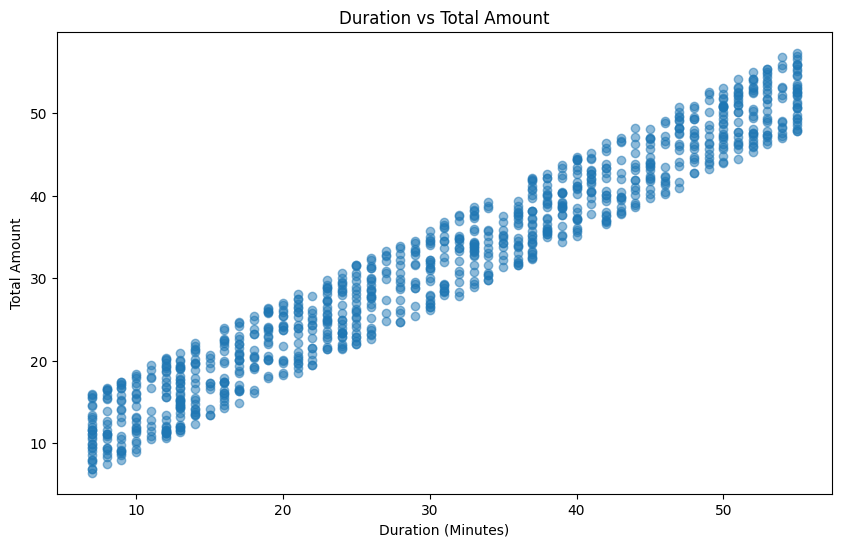

In [37]:
# get correlation
print(f'Correlation between duration and total amount: {df.select("Duration_Min", "Total_Amount").corr("Duration_Min", "Total_Amount")}')

# plot a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.select('Duration_Min').toPandas(), df.select('Total_Amount').toPandas(), alpha=0.5)
plt.xlabel('Duration (Minutes)')
plt.ylabel('Total Amount')
plt.title('Duration vs Total Amount')
plt.show()


## Part F


### Key Insight 1: Trip Duration is the Overwhelming Factor in Determining Trip Revenue.

- Supporting Analysis: Exploration in Part 3.E, where I examined the relationship between Duration_Min and Total_Amount, revealed a very strong positive linear correlation (0.973).

- Description: This indicates that the length of time a trip takes is the primary determinant of the total amount collected (which includes the fare and any tip). While other factors might play minor roles, duration stands out.


### Key Insight 2: While Overall Average Earnings Show Little Difference by Gender or Weekday/Weekend, Strategic Positioning by Location and Time of Day Can Optimize Earnings for Specific Driver Groups.

Supporting Analysis:
- Part 3.A: showed no significant difference in average nightly earnings between male and female drivers.
- Part 3.B: t-test indicated no statistically significant difference in average earnings between weekends and weekdays.
- Part 3.C: analysis of profitable states showed that while overall differences were sometimes not statistically significant after strict corrections, certain pickUp_Colombo_IDs appeared more lucrative for specific gender groups during 'Day' or 'Night' (e.g., Colombo ID 13 for men/night and women/day; Colombo ID 5 for women/night, with Colombo IDs 5 and 13 being good overall performers based on median earnings (and mean) comparisons).

Description: 
- Broadly, drivers (irrespective of gender) or days (weekday vs. weekend) don't show large, statistically significant differences in average earnings. However, the "best" pickup locations for profitable fares can change depending on whether it's 'Day' or 'Night' and potentially for male versus female drivers.

### Key Insight 3: Tipping Behavior Varies by Pickup Location, but Number of Passengers Doesn't Significantly Influence Overall Trip Earnings or Tips.

Supporting Analysis:
- Part 3.D: The analysis in Part 3.D showed that tipping behavior varied slightly by pickup location, with colombo 6 and 2 showing the highest tip percentages and also the highest absolute tip values
- Part 3.E: The analysis in Part 3.E showed that the number of passengers didn't significantly influence overall trip earnings or tips.

Description:
- Tipping behavior varied by pickup location, but the number of passengers didn't significantly influence overall trip earnings or tips.



# Part 4

## EDA

There is no real smooth and ordered syclical pattern so skip the fourier terms

In [38]:
df.groupBy('DayofWeek').agg(mean('Total_Amount').alias('mean_total_amount')).sort('mean_total_amount', ascending=False).show()

# remove DayofWeek column
df = df.drop('DayofWeek')


+---------+------------------+
|DayofWeek| mean_total_amount|
+---------+------------------+
|   Sunday|32.621071428571426|
|Wednesday| 32.55862745098039|
| Saturday|32.159575757575745|
|   Monday|31.659574468085108|
|   Friday| 30.53710059171598|
| Thursday|30.382330827067694|
|  Tuesday| 30.09683673469388|
+---------+------------------+



In [39]:
df = df.orderBy('Date', ascending=True)
df

Cab_Driver_ID,IsMale,PickUp_Colombo_ID,DropOff_Colombo_ID,N_Passengers,Date,PickUp_Time,Duration_Min,Tip,Total_Amount
10,1,12,9,4,2021-07-01,Night,14,1.98,14.16
16,0,10,10,2,2021-07-01,Day,42,2.84,39.38
10,1,9,13,1,2021-07-01,Day,15,3.47,16.52
19,0,11,10,3,2021-07-01,Day,53,9.23,55.34
1,1,8,6,4,2021-07-01,Day,13,4.48,15.79
1,1,5,6,1,2021-07-02,Day,51,6.6,50.97
11,1,6,11,4,2021-07-02,Day,16,3.53,17.45
6,1,13,8,4,2021-07-02,Night,13,5.35,16.66
20,0,9,11,4,2021-07-02,Day,25,1.15,22.9
5,1,11,1,4,2021-07-02,Day,12,2.31,12.75


## Part A


- 70/30 split for training and testing based on Date to avoid data leakage from the future.

In [40]:
from pyspark.sql.functions import row_number, monotonically_increasing_id, lit, col
from pyspark.sql.window import Window


df_ordered = df.withColumn("unique_id_for_split", monotonically_increasing_id())
window_spec = Window.orderBy(col("Date"), col("unique_id_for_split"))

df_with_index = df_ordered.withColumn("row_num", row_number().over(window_spec))

total_rows = df_with_index.count()
train_percentage = 0.7
split_point = int(total_rows * train_percentage)

train_df = df_with_index.filter(col("row_num") <= split_point).drop("row_num", "unique_id_for_split")
test_df = df_with_index.filter(col("row_num") > split_point).drop("row_num", "unique_id_for_split")

print(f"Total rows: {total_rows}")
print(f"Training set rows: {train_df.count()}, Expected: {split_point}")
print(f"Testing set rows: {test_df.count()}, Expected: {total_rows - split_point}")

Total rows: 999
Training set rows: 699, Expected: 699
Testing set rows: 300, Expected: 300


## Part B

Feature engineering : Want to preserve interpretability so we avoid using things like PCA and introducing lots of dimensions for now.
- drop Cab_driver_ID (we dont want the model to be only for existing cab drivers)
- leave isMale as it is
- PickUP ID and DropOff ID need to be one hot encoded
- N passenders also left as it is
- Date in itself is not particularly important since we dont want there to be a temporal component. Instead we use day of the week (one hot encoded).
- PickUp_Time is important and we should do a binary encoding for it.
- Duration_Minutes will be left as it is
- Tip should not be seen by the predictive model as it comes after the trip. drop it in the end.
- Total_Amount is the target variable and we should subtract the tip from it to get the amount the driver will see.

In [41]:
from pyspark.sql.functions import dayofweek


def initial_transformation(df):
    # subtract tip from total amount
    df_transformed = df.withColumn("Fare", col("Total_Amount") - col("Tip"))

    # add day of the week
    df_transformed = df_transformed.withColumn("DayOfWeek", dayofweek(col("Date")))

    # drop the columns that are not needed
    columns_to_drop = ["Cab_Driver_ID", "Tip", "Date", "Total_Amount"]
    df_transformed = df_transformed.drop(*columns_to_drop)

    return df_transformed

train_df = initial_transformation(train_df)
test_df = initial_transformation(test_df)

train_df.show(5)
test_df.show(5)




+------+-----------------+------------------+------------+-----------+------------+------------------+---------+
|IsMale|PickUp_Colombo_ID|DropOff_Colombo_ID|N_Passengers|PickUp_Time|Duration_Min|              Fare|DayOfWeek|
+------+-----------------+------------------+------------+-----------+------------+------------------+---------+
|     1|               12|                 9|           4|      Night|          14|             12.18|        5|
|     0|               10|                10|           2|        Day|          42|36.540000000000006|        5|
|     1|                9|                13|           1|        Day|          15|13.049999999999999|        5|
|     0|               11|                10|           3|        Day|          53|             46.11|        5|
|     1|                8|                 6|           4|        Day|          13|11.309999999999999|        5|
+------+-----------------+------------------+------------+-----------+------------+-------------

In [42]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline



pipeline_stages = []

# leave ismale as it is

# OHE pickup and dropoff
pickup_indexer = StringIndexer(inputCol="PickUp_Colombo_ID", outputCol="PickUp_ID_Index", handleInvalid="keep")
pickup_encoder = OneHotEncoder(inputCol="PickUp_ID_Index", outputCol="PickUp_ID_OHE")
pipeline_stages.extend([pickup_indexer, pickup_encoder])

dropoff_indexer = StringIndexer(inputCol="DropOff_Colombo_ID", outputCol="DropOff_ID_Index", handleInvalid="keep")
dropoff_encoder = OneHotEncoder(inputCol="DropOff_ID_Index", outputCol="DropOff_ID_OHE")
pipeline_stages.extend([dropoff_indexer, dropoff_encoder])

# leaven_passengers as it is

# binary encode pickup_time
pickup_time_indexer = StringIndexer(inputCol="PickUp_Time", outputCol="PickUp_Time_Binary", handleInvalid="keep")
pipeline_stages.extend([pickup_time_indexer])

# leave duration minutes as it is

# one hot encode day of the week
dayofweek_indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_Index", handleInvalid="keep")
dayofweek_encoder = OneHotEncoder(inputCol="DayOfWeek_Index", outputCol="DayOfWeek_OHE")
pipeline_stages.extend([dayofweek_indexer, dayofweek_encoder])



# assember
feature_columns_to_assemble = [
    "IsMale", 
    "PickUp_ID_OHE",
    "DropOff_ID_OHE",
    "N_Passengers",
    "PickUp_Time_Binary",
    "Duration_Min",
    "DayOfWeek_OHE",
]
assembler = VectorAssembler(inputCols=feature_columns_to_assemble, outputCol="features")
pipeline_stages.extend([assembler])

# # add a scaler
# scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
# pipeline_stages.extend([scaler])



# pipeline
pipeline = Pipeline(stages=pipeline_stages)

In [43]:
fitted_pipe = pipeline.fit(train_df)

train_transformed = fitted_pipe.transform(train_df)
test_transformed = fitted_pipe.transform(test_df)

In [44]:
# train the model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Fare")

lr_model = lr.fit(train_transformed)

- residuals look normally distributed with mean very close to zero. 
- we tend to underpredict at lower fares and overpredict at higher fares - this seems to go away when we normalize the features but that makes the model less interpretable and the overall results remain the same

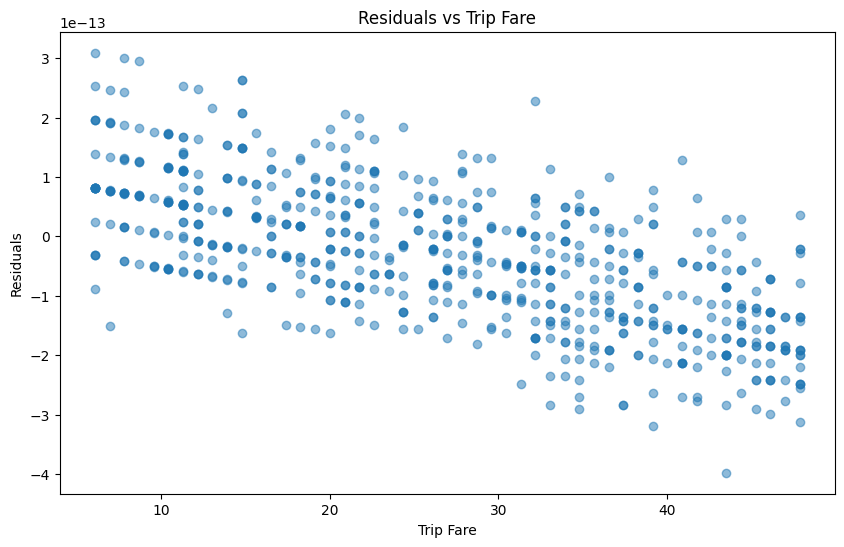

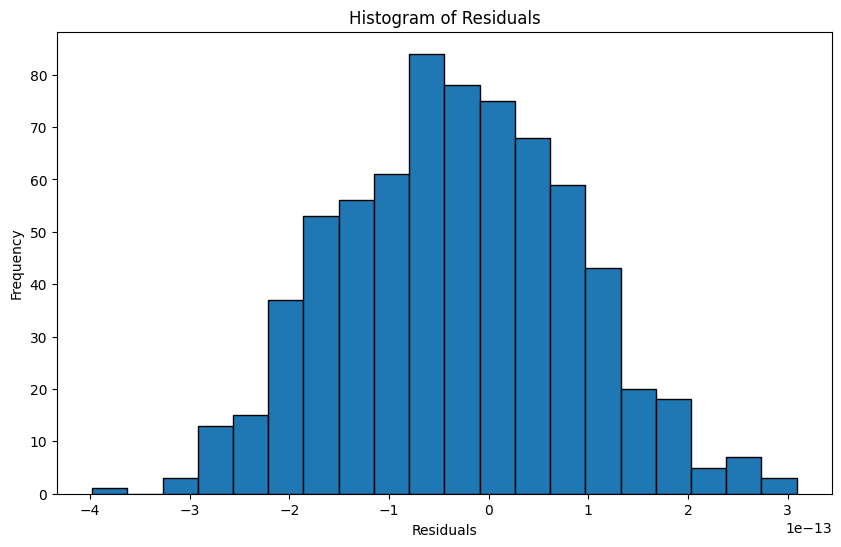

Average residual: [-3.21815377e-14]


In [45]:
# check residuals
residuals = lr_model.transform(train_transformed).select("Fare", "prediction")

# add column for residuals
residuals = residuals.withColumn("residuals", col("Fare") - col("prediction"))

# plot residuals against true fare
plt.figure(figsize=(10, 6))
plt.scatter(residuals.select("Fare").toPandas(), residuals.select("residuals").toPandas(), alpha=0.5)
plt.xlabel("Trip Fare")
plt.ylabel("Residuals")
plt.title("Residuals vs Trip Fare")
plt.show()


# plot residuals histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals.select("residuals").toPandas(), bins=20, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


# print average residual
print(f"Average residual: {residuals.select(mean('residuals')).toPandas().values[0]}")


Making predictions on the test data...

Sample predictions (showing features, Fare, and prediction):
+--------------------------------------------------------+------------------+------------------+
|features                                                |Fare              |prediction        |
+--------------------------------------------------------+------------------+------------------+
|(42,[2,21,32,34,37],[1.0,1.0,4.0,19.0,1.0])             |16.53             |16.529999999999973|
|(42,[0,10,25,32,34,40],[1.0,1.0,1.0,4.0,38.0,1.0])      |33.06             |33.060000000000116|
|(42,[0,9,26,32,34,40],[1.0,1.0,1.0,4.0,55.0,1.0])       |47.85             |47.85000000000025 |
|(42,[0,10,27,32,34,40],[1.0,1.0,1.0,4.0,33.0,1.0])      |28.709999999999997|28.710000000000036|
|(42,[0,14,19,32,33,34,40],[1.0,1.0,1.0,4.0,1.0,8.0,1.0])|6.96              |6.959999999999809 |
+--------------------------------------------------------+------------------+------------------+
only showing top 5 rows



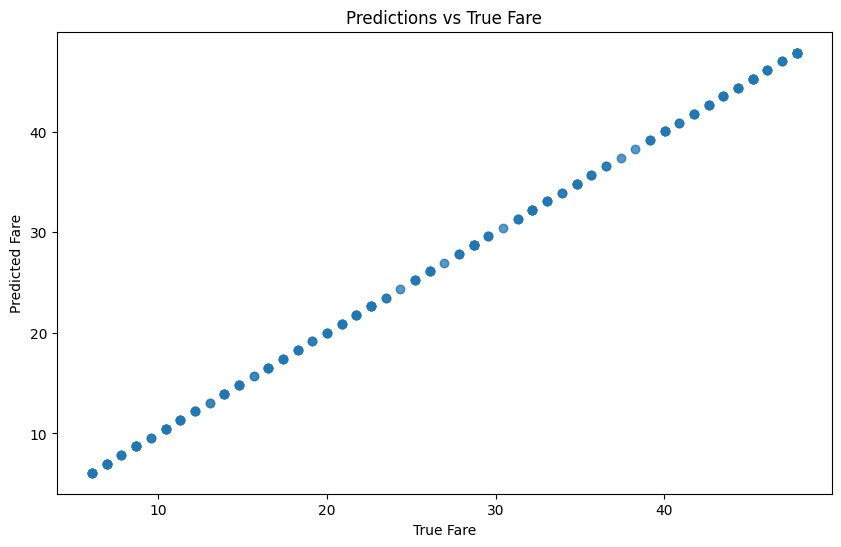


Evaluating model performance...

--- Model Evaluation Metrics ---
Root Mean Squared Error (RMSE) on test data: 0.0000
Mean Squared Error (MSE) on test data: 0.0000
R-squared (R2) on test data: 1.0000
Mean Absolute Error (MAE) on test data: 0.0000


In [46]:
from pyspark.ml.evaluation import RegressionEvaluator

print("\nMaking predictions on the test data...")
predictions_df = lr_model.transform(test_transformed)

print("\nSample predictions (showing features, Fare, and prediction):")
predictions_df.select("features", "Fare", "prediction").show(5, truncate=False)


# plot predictions vs true fare
plt.figure(figsize=(10, 6))
plt.scatter(predictions_df.select("Fare").toPandas(), predictions_df.select("prediction").toPandas(), alpha=0.5)
plt.xlabel("True Fare")
plt.ylabel("Predicted Fare")
plt.title("Predictions vs True Fare")
plt.show()

# print evaluation metrics
print("\nEvaluating model performance...")

# Create a RegressionEvaluator
evaluator_rmse = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="rmse")
evaluator_mse = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="mse")
evaluator_r2 = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="Fare", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(predictions_df)
mse = evaluator_mse.evaluate(predictions_df)
r2 = evaluator_r2.evaluate(predictions_df)
mae = evaluator_mae.evaluate(predictions_df)

print(f"\n--- Model Evaluation Metrics ---")
print(f"Root Mean Squared Error (RMSE) on test data: {rmse:.4f}")
print(f"Mean Squared Error (MSE) on test data: {mse:.4f}")
print(f"R-squared (R2) on test data: {r2:.4f}")
print(f"Mean Absolute Error (MAE) on test data: {mae:.4f}")



- The model seems a bit too good to be true. But I checked the pipeline and it seems like the relationship is completely linear.

## Part C

Now lets interpret the model and give reccomendations to drivers

/var/folders/26/gpxb1mwx5zd590_4yvmsyt0m0000gn/T/ipykernel_9210/2188332348.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_positive_coeffs_df, palette="viridis")


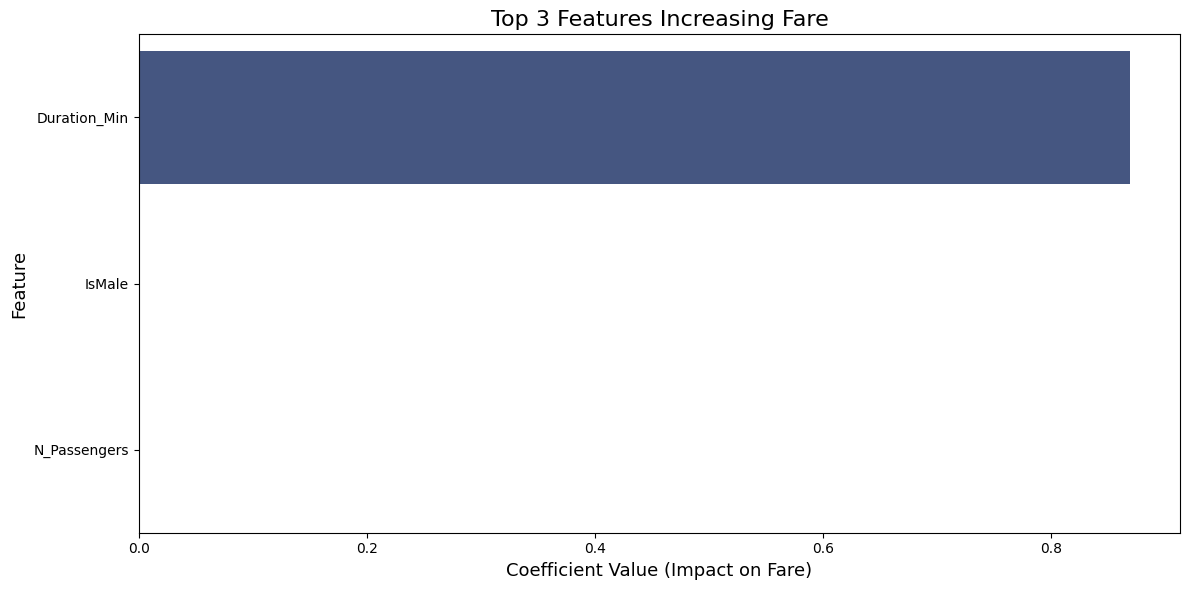

In [47]:
def get_feature_names_from_metadata(df_with_features_col, features_col_name="features"):
        schema = df_with_features_col.schema

        attrs_metadata = schema[features_col_name].metadata.get("ml_attr", {})
        
        # Check if 'attrs' or 'attributes' key exists (Spark versions might vary slightly)
        attrs_list_container = attrs_metadata.get("attrs", attrs_metadata.get("attributes"))

        feature_names = []
        # attrs_list_container can have 'numeric' and 'binary' (or 'nominal') keys
        all_attrs_list = []
        if "numeric" in attrs_list_container:
            all_attrs_list.extend(attrs_list_container["numeric"])
        if "binary" in attrs_list_container: # For OHE features typically
            all_attrs_list.extend(attrs_list_container["binary"])
        if "nominal" in attrs_list_container: # Sometimes used instead of/with binary
             all_attrs_list.extend(attrs_list_container["nominal"])
        
        if not all_attrs_list:
            print(f"Warning: No 'numeric', 'binary', or 'nominal' attributes found in metadata for '{features_col_name}'.")
            return None


        for attr in all_attrs_list:
            if "idx" not in attr:
                print(f"Warning: Attribute {attr.get('name', 'Unknown')} is missing 'idx'. Cannot guarantee order.")
        
        # Let's try sorting if 'idx' is present, otherwise use the order as received.
        if all(isinstance(attr, dict) and "idx" in attr for attr in all_attrs_list):
            all_attrs_sorted = sorted(all_attrs_list, key=lambda x: x["idx"])
        else:
            print("Warning: Not all attributes have an 'idx' field. Using order as received from metadata.")
            all_attrs_sorted = all_attrs_list # Rely on Spark's internal order

        feature_names = [attr.get("name", f"unknown_feature_{i}") for i, attr in enumerate(all_attrs_sorted)]
        
        return feature_names
    

def plot_coefficients(model_coeffs, feature_names, k = 10):
    if len(model_coeffs) != len(feature_names):
        print(f"Error: Mismatch between number of coefficients ({len(model_coeffs)}) and feature names ({len(feature_names)}). Cannot plot.")
        return

    coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model_coeffs})
    positive_coeffs_df = coeff_df[coeff_df['Coefficient'] > 0].copy()

    if positive_coeffs_df.empty:
        print("No features found with a positive coefficient.")
        return

    top_positive_coeffs_df = positive_coeffs_df.sort_values(by='Coefficient', ascending=False).head(k)

    if top_positive_coeffs_df.empty:
        print(f"No positive coefficients to plot for top {k}.")
        return

    plt.figure(figsize=(12, k * 0.6))
    sns.barplot(x='Coefficient', y='Feature', data=top_positive_coeffs_df, palette="viridis")
    plt.title(f'Top {len(top_positive_coeffs_df)} Features Increasing Fare', fontsize=16)
    plt.xlabel('Coefficient Value (Impact on Fare)', fontsize=13)
    plt.ylabel('Feature', fontsize=13)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    plt.show()
     

feature_names = get_feature_names_from_metadata(train_transformed, "features")

plot_coefficients(lr_model.coefficients, feature_names, k=10)

- The conclusion is that drivers should focus almost entirely on the duration of the trip. For every (approximately) 54 seconds they travel, they can expect to make 1 unit of fare - check how long the trip will take on google maps.

- This can be integrated into the meter but it doesnt do anything additional from what the meter already does. If anything, the meter also takes distance into consideration so it might be better to leave it as is.
